In [1]:
import os
import anndata as ad
import scanpy as sc
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import scvi
import scanpy.external as sce
import pertpy as pt
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

/home/icb/martin.meinel/miniconda3/envs/pbeqtl_39/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
adata_combined = sc.read_h5ad("/Safari/sc/combined_adata_haniffa_mf_ad_pso_harmony.h5ad")

In [ ]:
adata_combined.obs.groupby("disease")["sample"].nunique()

disease
AE      7
MF     11
Pso    11
Name: sample, dtype: int64

In [4]:
adata_combined.obsm

AxisArrays with keys: X_pca, X_pca_harmony, X_umap

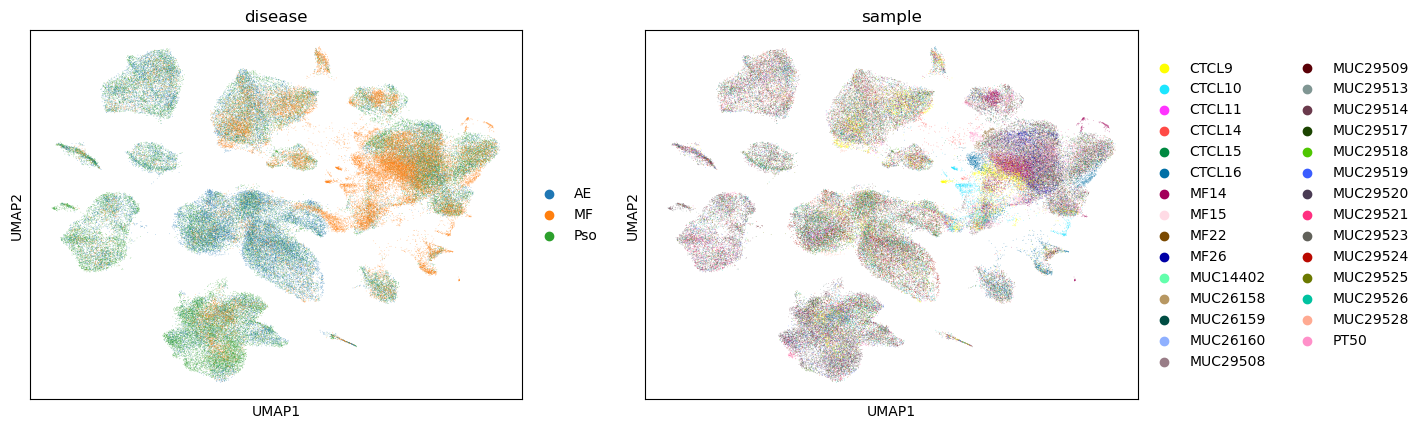

In [7]:
sc.pl.umap(adata_combined, color=["disease", "sample"], alpha=0.5)

In [8]:
sc.tl.leiden(adata_combined, resolution=1., key_added="leiden_harmony_res1")

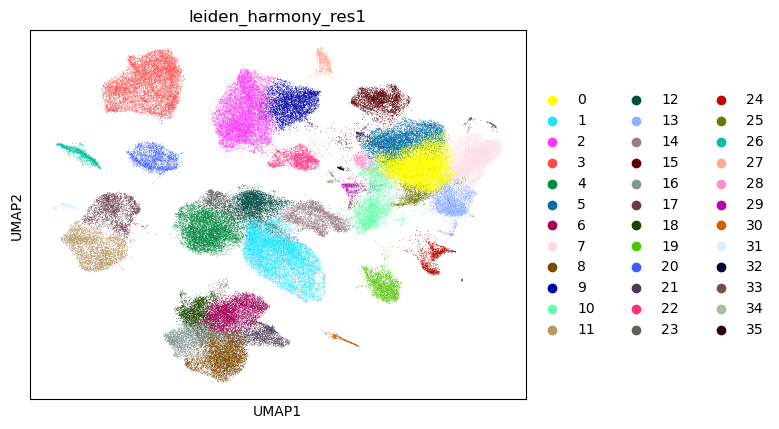

In [9]:
sc.pl.umap(adata_combined, color="leiden_harmony_res1")

In [11]:
marker_genes = {
    "Macrophages": ["AIF1"],
    "Endothelial cells": ["VWF"],
    "Mast cells": ["CPA3"],
    "Pericytes": ["RGS5"],
    "Melanocytes": ["PMEL"],
    "B cells": ["MS4A1"],
    "Keratinocytes": ["KRT1"],
    "Smooth muscle cells": ["DES"],
    "Fibroblasts": ["COL1A1"],
    "T lymphocytes": ["CD3D"],
    "Dendritic cells": ["CD1C"],
    "NK": ["NCAM1"]
}

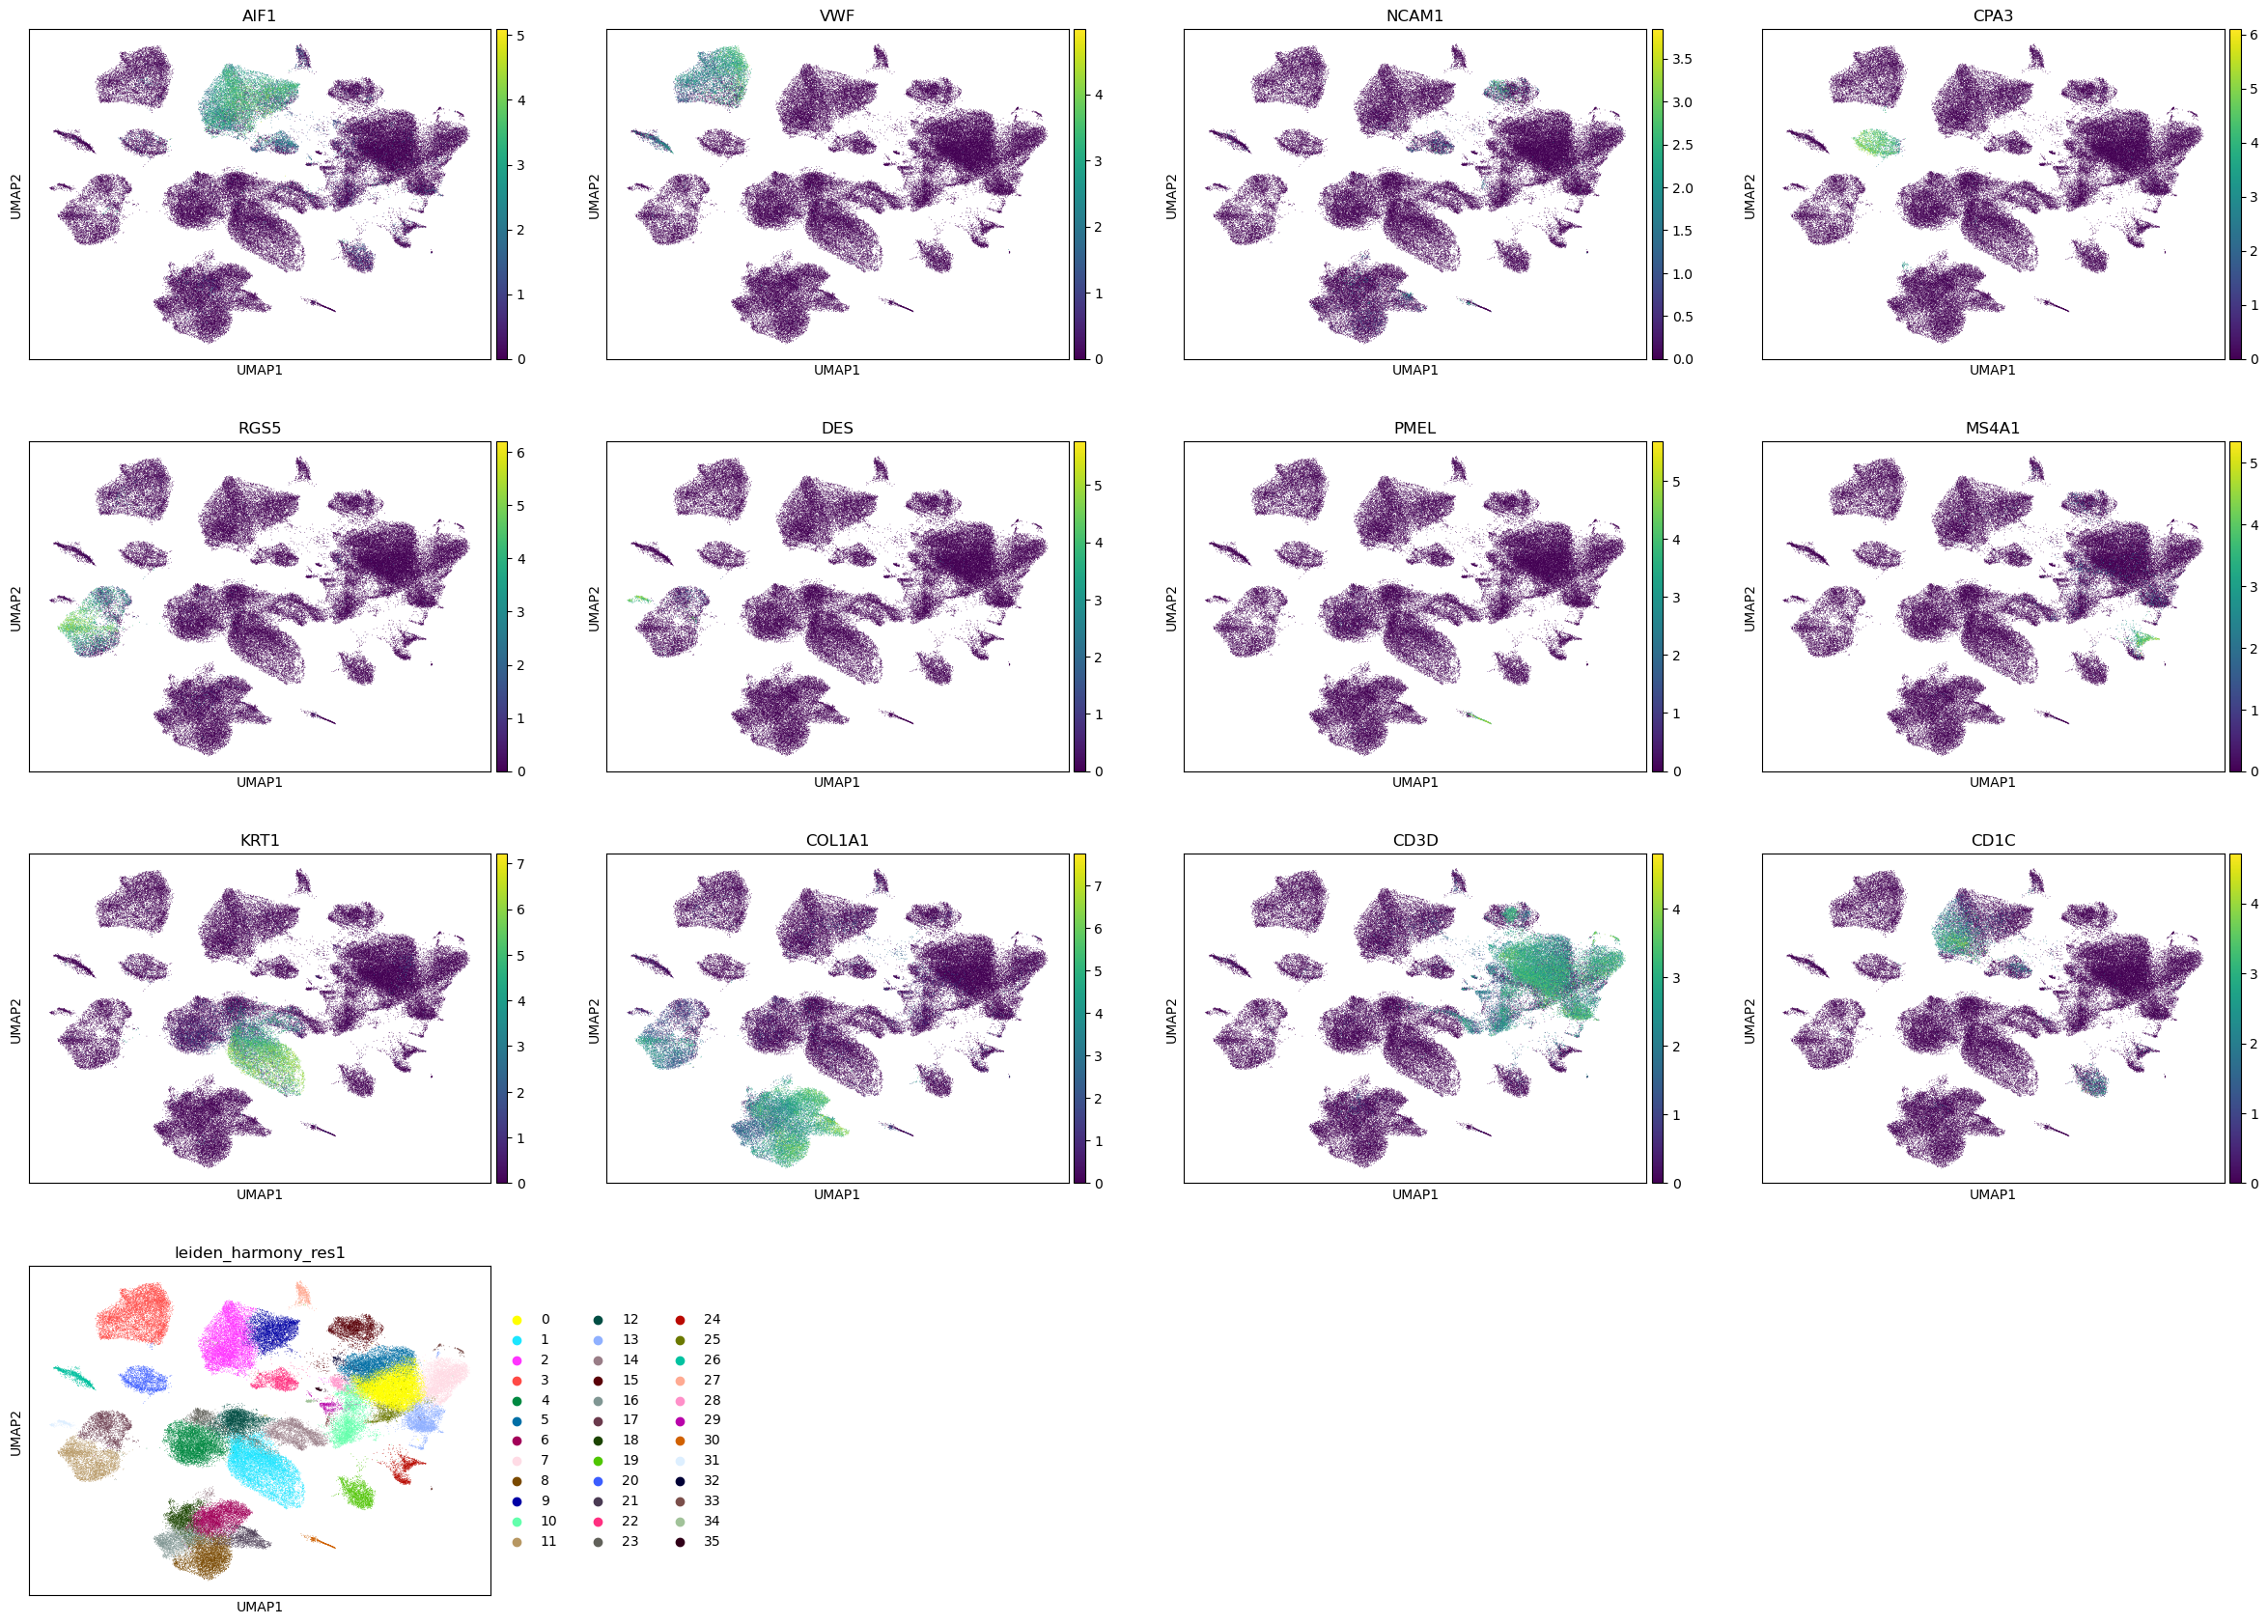

In [12]:
sc.pl.umap(adata_combined, color=["AIF1", "VWF", "NCAM1", "CPA3", "RGS5", "DES","PMEL", "MS4A1", "KRT1", "COL1A1", "CD3D", "CD1C", "leiden_harmony_res1"], show=True, use_raw=True)

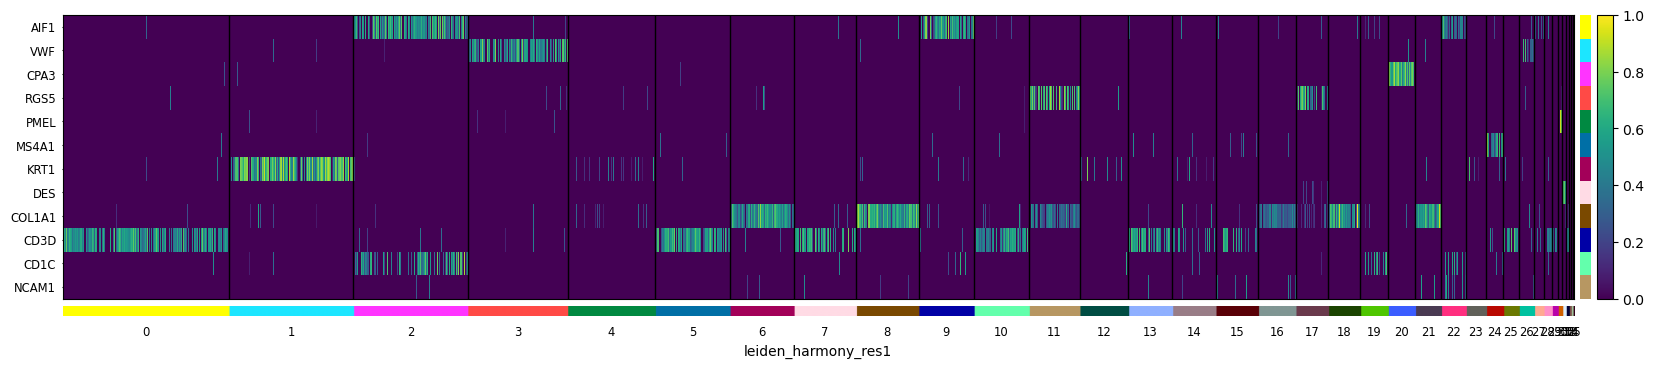

In [13]:
sc.pl.heatmap(adata_combined, var_names=marker_genes, groupby="leiden_harmony_res1", use_raw=True, swap_axes=True, standard_scale="var", show_gene_labels=True, figsize=(20, 4))

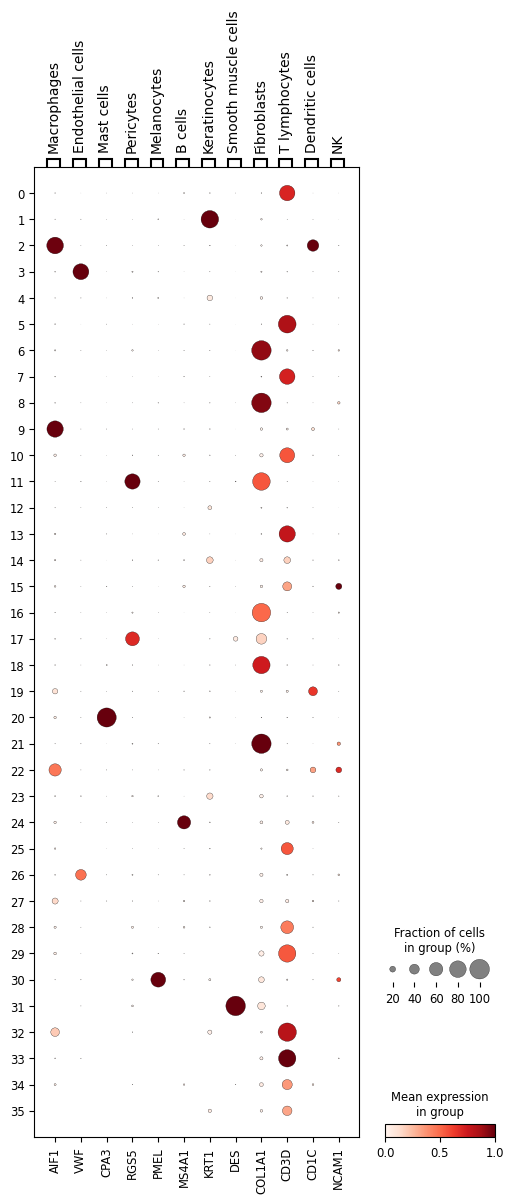

In [14]:
coarse_dotplot = sc.pl.dotplot(adata_combined, marker_genes, groupby="leiden_harmony_res1", standard_scale="var", show=True, use_raw=True)

In [103]:
celltype_mapping_leiden = {
    "0": "T lymphocytes",
    "1": "Keratinocytes", 
    "2": "Macrophages", # Split here MAcrophagesa and DCs -- Done
    "3": "Endothelial cells",
    "4": "Keratinocytes",
    "5": "T lymphocytes",
    "6": "Fibroblasts",
    "7": "T lymphocytes",
    "8": "Fibroblasts",
    "9": "Macrophages",
    "10": "T lymphocytes",
    "11": "Pericytes", # Split betweedn fibroblasts and pericytes
    "12": "Keratinocytes",
    "13": "T lymphocytes", 
    "14": "Keratinocytes", # Split between T lmyphocytes and keratinocytes
    "15": "T lymphocytes", # Split between NK and T lymphocytes
    "16": "Fibroblasts", 
    "17": "Pericytes", # Split between Fibroblasts and pericytes
    "18": "Fibroblasts",
    "19": "Dendritic cells",
    "20": "Mast cells",
    "21": "Fibroblasts",
    "22": "Macrophages",
    "23": "Keratinocytes",
    "24": "B cells",
    "25": "T lymphocytes",
    "26": "Endothelial cells",
    "27": "Macrophages",
    "28": "T lymphocytes",
    "29": "T lymphocytes",
    "30": "Melanocytes",
    "31": "Smooth muscle cells",
    "32": "T lymphocytes",
    "33": "T lymphocytes",
    "34": "T lymphocytes",
    "35": "T lymphocytes"
}

In [75]:
adata_combined.obs.columns

Index(['sample', 'disease', 'cell_types', 'n_counts', 'n_genes', 'mt_counts',
       'mt_frac', 'scrublet_score', 'predicted_doublet', 'doublet_score',
       'dataset_batch', 'leiden_harmony_res1', 'cell_tpye_coarse_martin_v1'],
      dtype='object')

In [101]:
adata_combined.obs["cell_type_coarse_martin_v1"] = adata_combined.obs["leiden_harmony_res1"].map(celltype_mapping_leiden)

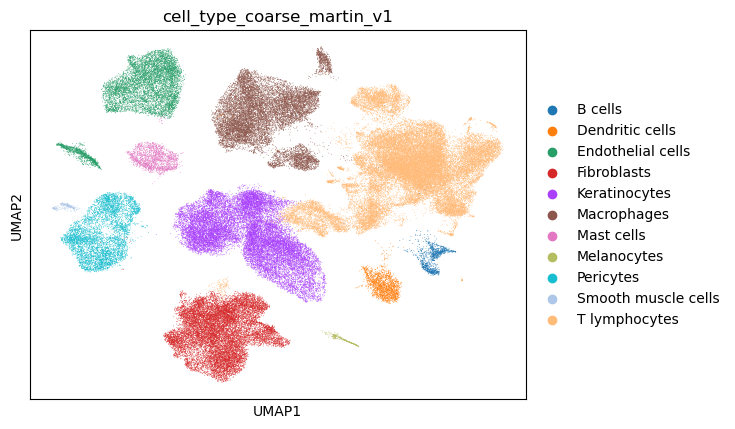

In [102]:
sc.pl.umap(adata_combined, color="cell_type_coarse_martin_v1")

In [107]:
# CLUSTER2
cluster2 = adata_combined[adata_combined.obs["leiden_harmony_res1"] == "2",].copy()
cd1c_positive_cell_mask = cluster2.raw[:, "CD1C"].X.toarray().flatten() > 0
aif1_positive_cell_mask = cluster2.raw[:, "AIF1"].X.toarray().flatten() > 0
dendritic_cells_cluster2 = cluster2[cd1c_positive_cell_mask,].obs_names
macrophages_cluster2 = cluster2[aif1_positive_cell_mask,].obs_names

# CLUSTER 11
cluster11 = adata_combined[adata_combined.obs["leiden_harmony_res1"] == "11",].copy()
rgs5_positive_cell_mask_cluster11 = cluster11.raw[:, "RGS5"].X.toarray().flatten() > 0
col1a1_positive_cell_mask_cluster11 = cluster11.raw[:, "COL1A1"].X.toarray().flatten() > 0
pericytes_cluster11 = cluster11[rgs5_positive_cell_mask_cluster11,].obs_names
fibroblasts_cluster11 = cluster11[col1a1_positive_cell_mask_cluster11,].obs_names

# Cluster 14 KRt and T clels
cluster14 = adata_combined[adata_combined.obs["leiden_harmony_res1"] == "14",].copy()
krt1_positive_cell_mask_cluster14 = cluster14.raw[:, "KRT1"].X.toarray().flatten() > 0
cd3d_positive_cell_mask_cluster14 = cluster14.raw[:, "CD3D"].X.toarray().flatten() > 0
keratinocytes_cluster14 = cluster14[krt1_positive_cell_mask_cluster14,].obs_names
t_cells_cluster14 = cluster14[cd3d_positive_cell_mask_cluster14,].obs_names

# CLUSTER 15 Tlymphocytes and KRT
cluster15 = adata_combined[adata_combined.obs["leiden_harmony_res1"] == "15",].copy()
cd3d_positive_cell_mask = cluster15.raw[:, "CD3D"].X.toarray().flatten() > 0
ncam1_positive_cell_mask = cluster15.raw[:, "NCAM1"].X.toarray().flatten() > 0
nk_cell_mask = (ncam1_positive_cell_mask) & (~cd3d_positive_cell_mask)
tcells_cluster15 = cluster15[cd3d_positive_cell_mask].obs_names
nk_cells_cluster15 = cluster15[nk_cell_mask].obs_names

# CLUSTER 17
cluster17 = adata_combined[adata_combined.obs["leiden_harmony_res1"] == "17",].copy()
col1a1_positive_cell_mask_cluster17 = cluster17.raw[:, "COL1A1"].X.toarray().flatten() > 0
rgs5_positive_cell_mask_cluster17 = cluster17.raw[:, "RGS5"].X.toarray().flatten() > 0
fibroblasts_cluster17 = cluster17[col1a1_positive_cell_mask_cluster17,].obs_names
pericytes_cluster17 = cluster17[rgs5_positive_cell_mask_cluster17,].obs_names

adata_combined.obs["cell_type_coarse_martin_v2"] = "unlabelled"

adata_combined.obs.loc[macrophages_cluster2, "cell_type_coarse_martin_v2"] = "Macrophages"
adata_combined.obs.loc[dendritic_cells_cluster2, "cell_type_coarse_martin_v2"] = "Dendritic cells"

adata_combined.obs.loc[pericytes_cluster11, "cell_type_coarse_martin_v2"] = "Pericytes"
adata_combined.obs.loc[fibroblasts_cluster11, "cell_type_coarse_martin_v2"] = "Fibroblasts"

adata_combined.obs.loc[keratinocytes_cluster14, "cell_type_coarse_martin_v2"] = "Keratinocytes"
adata_combined.obs.loc[t_cells_cluster14, "cell_type_coarse_martin_v2"] = "T lymphocytes"

adata_combined.obs.loc[tcells_cluster15, "cell_type_coarse_martin_v2"] = "T lymphocytes"
adata_combined.obs.loc[nk_cells_cluster15, "cell_type_coarse_martin_v2"] = "NK cells"

adata_combined.obs.loc[fibroblasts_cluster17, "cell_type_coarse_martin_v2"] = "Fibroblasts"
adata_combined.obs.loc[pericytes_cluster17, "cell_type_coarse_martin_v2"] = "Pericytes"

unlabelled_mask = adata_combined.obs["cell_type_coarse_martin_v2"] == "unlabelled"
adata_combined.obs.loc[unlabelled_mask, "cell_type_coarse_martin_v2"] = adata_combined.obs.loc[unlabelled_mask, "cell_type_coarse_martin_v1"]

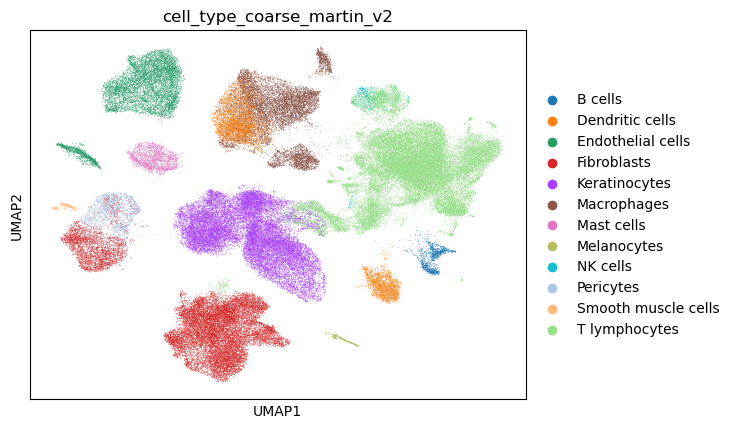

In [108]:
sc.pl.umap(adata_combined, color="cell_type_coarse_martin_v2")

In [110]:
t_lymphocytes = adata_combined[adata_combined.obs["cell_type_coarse_martin_v2"] == "T lymphocytes", ].copy()

In [112]:
cd3_mask = t_lymphocytes.raw[:, "CD3D"].X.toarray().flatten() > 0
cd4_mask = t_lymphocytes.raw[:, "CD4"].X.toarray().flatten() > 0
cd8_mask = t_lymphocytes.raw[:, "CD8A"].X.toarray().flatten() > 0
double_negative_mask = (cd3_mask) & (~cd4_mask) & (~cd8_mask)
cd3_cd4_mask = (cd3_mask) & (cd4_mask) & (~cd8_mask)
cd3_cd8_mask = (cd3_mask) & (cd8_mask) & (~cd4_mask)
cd4_cells = t_lymphocytes[cd3_cd4_mask,].copy()
cd8_cells = t_lymphocytes[cd3_cd8_mask,].copy()
# Cd4 masks
cd4_cxcl13_mask = cd4_cells.raw[:, "CXCL13"].X.toarray().flatten() > 0
cd4_tnfrsf4_mask = cd4_cells.raw[:, "TNFRSF4"].X.toarray().flatten() > 0
cd4_mki67_mask = cd4_cells.raw[:, "MKI67"].X.toarray().flatten() > 0
cd4_foxp3_mask = cd4_cells.raw[:, "FOXP3"].X.toarray().flatten() > 0
# CD8 masks
cd8_cxcl13_mask = cd8_cells.raw[:, "CXCL13"].X.toarray().flatten() > 0
cd8_tnfrsf4_mask = cd8_cells.raw[:, "TNFRSF4"].X.toarray().flatten() > 0
cd8_mki67_mask = cd8_cells.raw[:, "MKI67"].X.toarray().flatten() > 0

In [113]:
cd3_negative_cells = t_lymphocytes[~cd3_mask,].obs_names
double_negative_cell_names = t_lymphocytes[double_negative_mask,].obs_names

cd4_cxcl13_cell_names = cd4_cells[cd4_cxcl13_mask,].obs_names
cd4_mki67_cell_names = cd4_cells[cd4_mki67_mask,].obs_names
cd4_foxp3_cell_names = cd4_cells[cd4_foxp3_mask,].obs_names
cd4_tnfrsf4_cell_names = cd4_cells[cd4_tnfrsf4_mask,].obs_names

cd8_cxcl13_cell_names = cd8_cells[cd8_cxcl13_mask,].obs_names
cd8_mki67_cell_names = cd8_cells[cd8_mki67_mask,].obs_names
cd8_tnfrsf4_cell_names = cd8_cells[cd8_tnfrsf4_mask,].obs_names

In [114]:
# Assign labels vectorized - last assignment overwrites previous if overlaps exist
adata_combined.obs["cell_type_granular_martin_v3"] = "unlabelled"
adata_combined.obs.loc[cd3_negative_cells, "cell_type_granular_martin_v3"] = np.nan
adata_combined.obs.loc[double_negative_cell_names, "cell_type_granular_martin_v3"] = "Double negative T cells"

# 2nd level annotation
adata_combined.obs.loc[cd4_cxcl13_cell_names, 'cell_type_granular_martin_v3'] = "Exhausted CD4+"
adata_combined.obs.loc[cd4_tnfrsf4_cell_names, 'cell_type_granular_martin_v3'] = "Activated CD4+"
adata_combined.obs.loc[cd4_mki67_cell_names, 'cell_type_granular_martin_v3'] = "Proliferating CD4+"
adata_combined.obs.loc[cd4_foxp3_cell_names, 'cell_type_granular_martin_v3'] = "CD4+ regulatory"
# CD8
adata_combined.obs.loc[cd8_cxcl13_cell_names, 'cell_type_granular_martin_v3'] = "Exhausted CD8+"
adata_combined.obs.loc[cd8_tnfrsf4_cell_names, 'cell_type_granular_martin_v3'] = "Activated CD8+"
adata_combined.obs.loc[cd8_mki67_cell_names, 'cell_type_granular_martin_v3'] = "Proliferating CD8+"

all_assigned_names = set(np.concatenate([
    cd3_negative_cells, double_negative_cell_names, 
    cd4_cxcl13_cell_names, cd4_mki67_cell_names, cd4_foxp3_cell_names, cd4_tnfrsf4_cell_names, 
    cd8_cxcl13_cell_names, cd8_mki67_cell_names, cd8_tnfrsf4_cell_names
]))

tcell_obs_names = t_lymphocytes.obs_names 

# Create a boolean mask: True for cells that are NOT in the assigned set
non_assigned_mask = ~tcell_obs_names.isin(all_assigned_names)

# Get the list of cell names that are T cells but didn't get a specific subtype label
non_assigned_tcells = tcell_obs_names[non_assigned_mask]

# --- 3. ASSIGN NaN to non-assigned T cells in the full object ---
# This uses the correct index (non_assigned_tcells) which consists of barcodes 
# present in adata_combined.obs_names
adata_combined.obs.loc[non_assigned_tcells, 'cell_type_granular_martin_v3'] = np.nan
undefined_mask = adata_combined.obs["cell_type_granular_martin_v3"] == "unlabelled"
adata_combined.obs.loc[undefined_mask, "cell_type_granular_martin_v3"] = adata_combined.obs.loc[undefined_mask, "cell_type_coarse_martin_v2"]

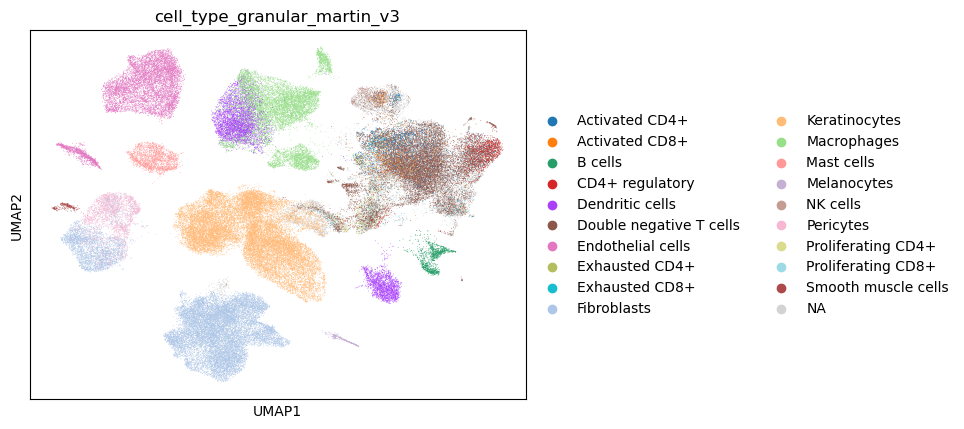

In [115]:
sc.pl.umap(adata_combined, color=["cell_type_granular_martin_v3"])

In [ ]:
sc.write("/Safari/sc/combined_adata_haniffa_harmony_granular_celltypes_ad_pso_mf.h5ad", adata_combined, compression="gzip")

# Paper Figures

In [125]:
# --- DEFINITIONS ---
target_markers = ['LCK', 'HOMER1']
# The subtype key is the newly aggregated column
subtype_key = 'cell_type_granular_martin_v3'
grouping_keys = ["disease"]

# Initialize a list to store results for the final DataFrame
results = []

# Loop through the two high-level grouping types ('disease' and 'condition')
for grouping_level in grouping_keys:
    
    # Loop through the target markers
    for marker in target_markers:
        
        # Check if the marker is available in the full AnnData object
        if marker not in adata_combined.var_names:
            print(f"Warning: Marker {marker} not found in adata_combined.")
            continue
            
        # 1. Extract expression (assumes .raw is the source for log-normalized counts)
        expression = adata_combined.raw[:, marker].X
        
        # 2. Prepare temporary DataFrame for calculation
        # This includes ALL cells and all coarse annotations
        temp_df = adata_combined.obs[[grouping_level, subtype_key]].copy()
        temp_df['expression'] = expression.toarray().flatten()
        
        # Define threshold for expression (e.g., > 0 for log-normalized data)
        threshold = 0
        temp_df['is_expressing'] = temp_df['expression'] > threshold
        
        # --- CRITICAL SELF-NORMALIZATION STEP ---
        
        # 3. Denominator: Calculate the total count for each cell type within each group
        # This provides the denominator for SELF-NORMALIZATION (e.g., Total Keratinocytes in Psoriasis)
        total_celltype_count = temp_df.groupby([grouping_level, subtype_key], observed=False)[subtype_key].count()
        
        # 4. Grouping for Numerator and Mean
        grouped = temp_df.groupby([grouping_level, subtype_key], observed=False)
        
        # Calculate Mean Expression (Numerator is sum of expression / Count of all cells in group)
        mean_expression = grouped['expression'].mean()
        
        # Calculate Expressing Count (Numerator for Abundance Ratio)
        expressing_count = grouped['is_expressing'].sum()
        
        # 5. Abundance Ratio: Fraction of expressing cells within the total cell type count (Self-Normalization)
        abundance_ratio = expressing_count / total_celltype_count 
        
        # 6. Aggregate results
        for (grouping_value, subtype), mean_exp in mean_expression.items():
            # Skip rows where subtype is NaN (unannotated cells) if they exist
            if pd.isna(subtype):
                continue
                
            results.append({
                'marker': marker,
                'grouping_level': grouping_level,
                "grouping_value": grouping_value,
                'subtype': subtype,
                'mean_expression': mean_exp,
                'abundance_ratio': abundance_ratio.loc[(grouping_value, subtype)]
            })

# --- FINAL DATAFRAME CREATION ---
dotplot_df = pd.DataFrame(results)

print("Coarse cell type data frame created (coarse_dotplot_df).")
print(dotplot_df.head())

Coarse cell type data frame created (coarse_dotplot_df).
  marker grouping_level grouping_value          subtype  mean_expression  \
0    LCK        disease             AE   Activated CD4+         0.780337   
1    LCK        disease             AE   Activated CD8+         0.740280   
2    LCK        disease             AE          B cells         0.050344   
3    LCK        disease             AE  CD4+ regulatory         1.027044   
4    LCK        disease             AE  Dendritic cells         0.005762   

   abundance_ratio  
0         0.421769  
1         0.404762  
2         0.022989  
3         0.593103  
4         0.005984  


In [126]:
max_expression = np.max(dotplot_df["mean_expression"])
min_expression = np.min(dotplot_df["mean_expression"])
max_abundance_ratio = np.max(dotplot_df["abundance_ratio"])
min_abundance_ratio = np.min(dotplot_df["abundance_ratio"])

In [127]:
dotplot_df.loc[dotplot_df["mean_expression"] == max_expression, :]

marker grouping_level grouping_value         subtype  mean_expression  \
20    LCK        disease             MF  Activated CD8+          1.60116   

    abundance_ratio  
20         0.852542

In [128]:
dotplot_df.loc[dotplot_df["abundance_ratio"] == max_abundance_ratio, :]

marker grouping_level grouping_value             subtype  mean_expression  \
36    LCK        disease             MF  Proliferating CD8+         1.460892   

    abundance_ratio  
36         0.904294

In [ ]:

sc.settings.figdir="/Safari/Classifier/figures/sc_figure/haniffa/"

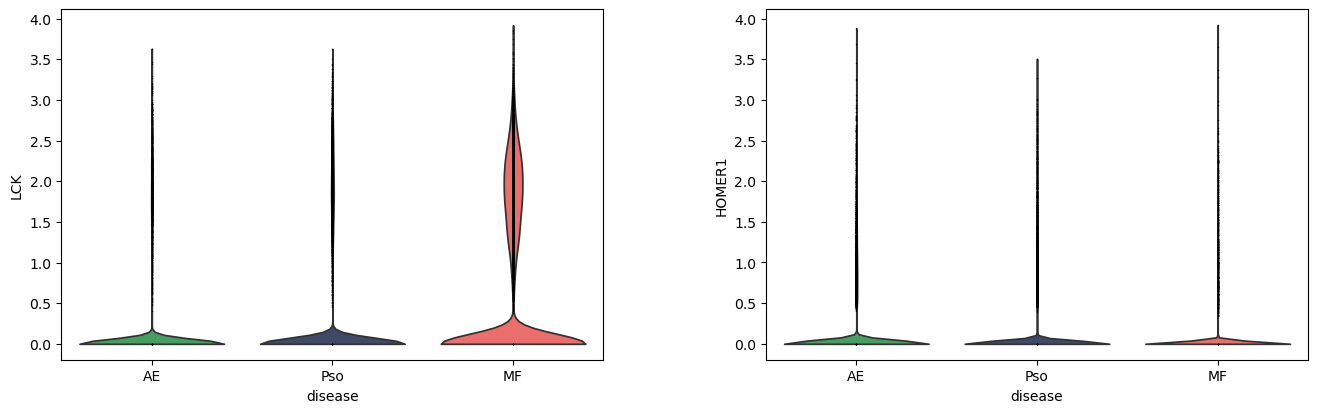

In [130]:
custom_palette = {"MF": "#ff5b57",
                  "Pso": "#39476e",
                  "AE": "#39ac5e"}
sc.pl.violin(adata_combined, keys=["LCK", "HOMER1"], groupby="disease",palette=custom_palette, order=["AE", "Pso", "MF"], jitter=False, use_raw=True, show=True, save="violin_pooled_MF_haniffa_final.png")

In [132]:
adata_combined.n_vars

15447

In [133]:
adata_combined.n_obs

104511

In [134]:
lck_max = np.max(adata_combined.raw[:, "LCK"].X)
homer_max = np.max(adata_combined.raw[:, "HOMER1"].X)
global_max= np.max([lck_max, homer_max])
global_max

np.float32(3.9188418)

Pso
AE
MF


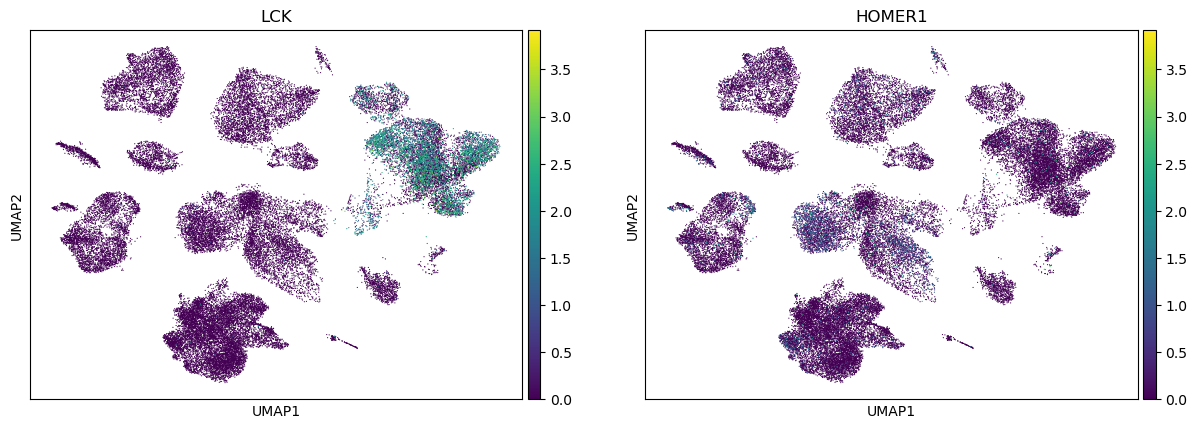

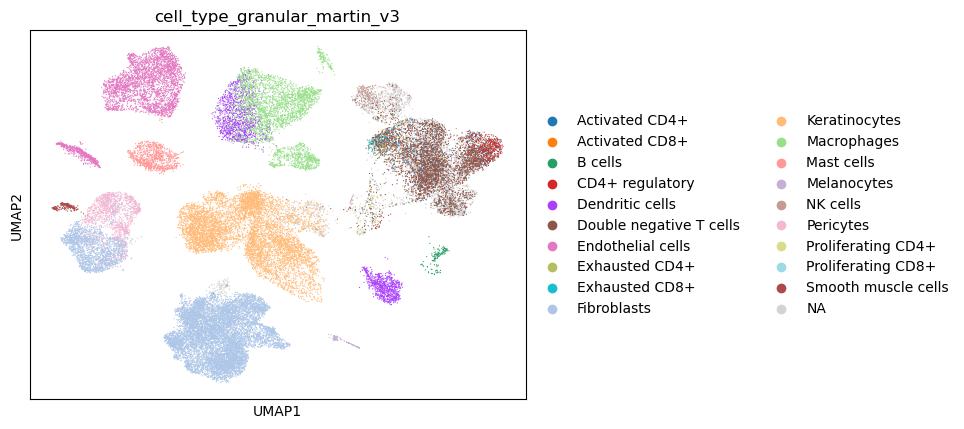

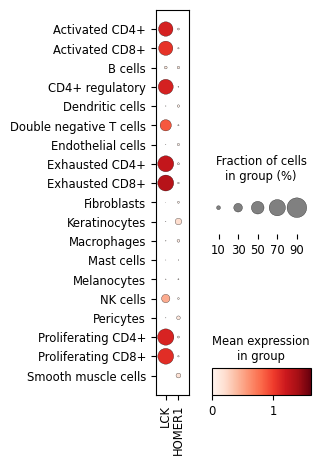

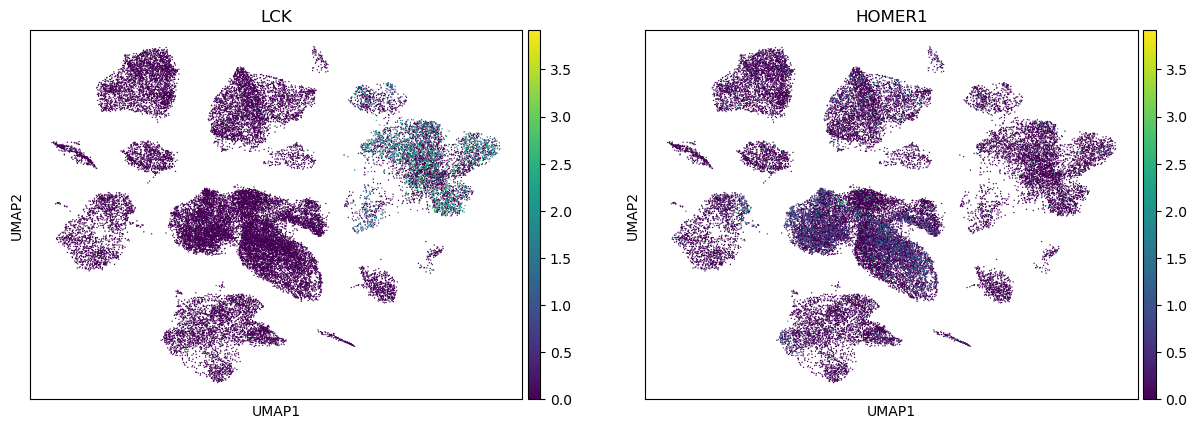

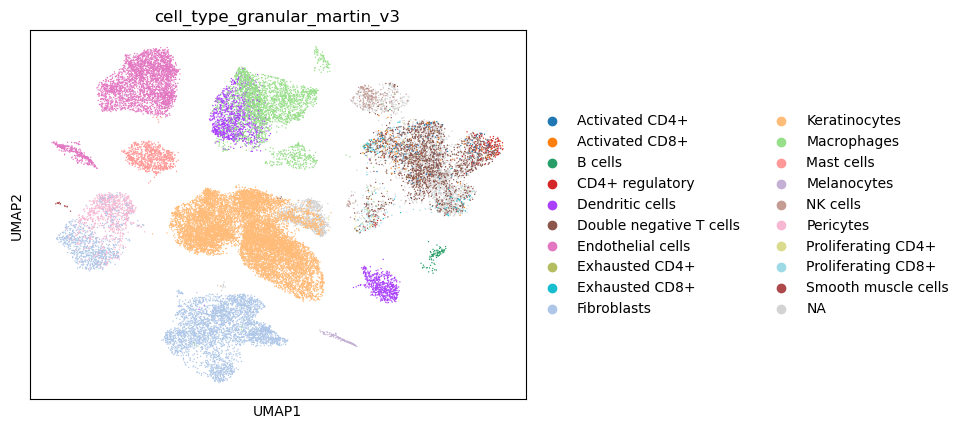

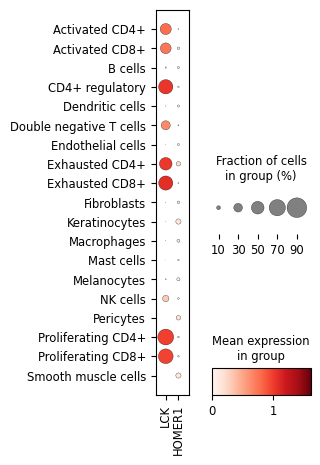

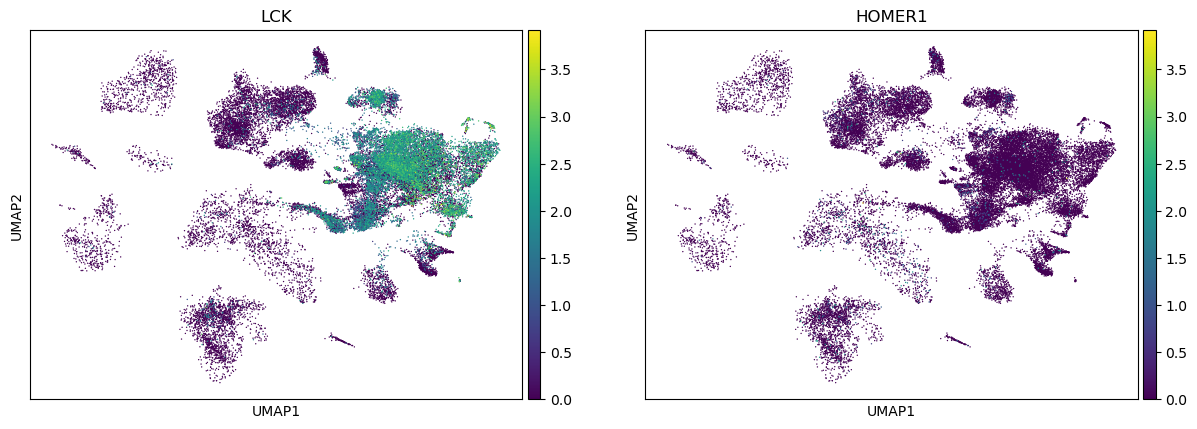

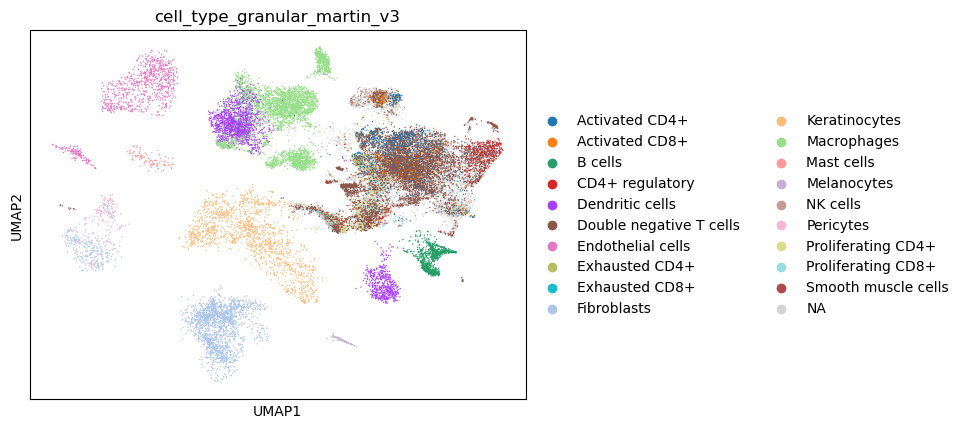

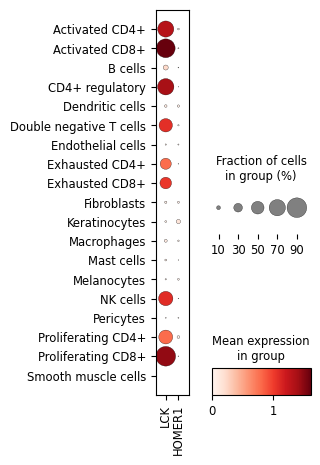

In [ ]:
for disease in adata_combined.obs["disease"].unique():
    print(disease)
    adata_disease = adata_combined[adata_combined.obs["disease"] == disease, ].copy()
    marker_umap = sc.pl.umap(adata_disease, color=["LCK", "HOMER1"], vmax = global_max, use_raw=True, show=False, return_fig=True)
    marker_umap.savefig(f"/figures/sc_figure/haniffa/marker_umap_{disease}_final.jpg", dpi=300,bbox_inches="tight")
    celltype_umap = sc.pl.umap(adata_disease, color="cell_type_granular_martin_v3", use_raw=True, show=False, return_fig=True)
    celltype_umap.savefig(f"/figures/sc_figure/haniffa/celltype_umap_{disease}_final.jpg", dpi=300,bbox_inches="tight")
    dotplot = sc.pl.dotplot(adata_disease, groupby="cell_type_granular_martin_v3",use_raw=True, var_names=["LCK", "HOMER1"], dot_min = min_abundance_ratio, dot_max=max_abundance_ratio, vmin=min_expression, vmax=max_expression, show=False, return_fig=True, figsize=(2,5))
    dotplot.savefig(f"/figures/sc_figure/haniffa/dotplot_{disease}_final.svg")